# Markov phenotyping

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import glob
import csv
import torch

import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from collections import defaultdict
from lifelines import KaplanMeierFitter

## ROI17 

## Loading the data
and getting it in the correct tensor format

In [40]:
path_to_table_data = r"\\store\department\gene\chien_data\Lab\Data_and_Analysis\Tsai-Ying_Chen\TYC070_EC546_TILs_72hr_20250328\72hr_recording_20250328at132435\results_frames_0_60_Wilco\tracking_results_from_Wilco_Segm"
# path_to_table_data = r"\\store\department\gene\chien_data\Lab\Data_and_Analysis\Tsai-Ying_Chen\TYC070_EC546_TILs_72hr_20250328\72hr_recording_20250328at132435\results_frames_40_60_Wilco\tb_copy_for_path"
frame_size = 61
cell_amount = 1326 # Amount of tracked Immune and Cancer cells

if not os.path.exists(path_to_table_data):
    print("path to table folder doesn't exist")

csv_files_paths = glob.glob(os.path.join(path_to_table_data, "*.csv"))

tensor_list = []
feature_name_list = []
# print(len(csv_files_paths))

for csv_file_path in csv_files_paths:

    feature_name = os.path.splitext(os.path.basename(csv_file_path))[0]
    feature_name_list.append(feature_name)
    print(feature_name)
    # print(feature_name_list)
    # print(len(feature_name_list))

    with open(csv_file_path, newline = '') as csvfile:
        reader = csv.reader(csvfile)
        data = [list(map(float, row)) for row in reader]
        data_tensor = torch.tensor(data, dtype=torch.float32)

        # Pad the columns (if there is only 1 value for the cells so not throught time, just add that value to all time)
        if data_tensor.shape[1] == 1:
            data_tensor = data_tensor.repeat(1, frame_size)

        # Pad the rows with 0's (missing cell id's (most likely immune cells))
        if data_tensor.shape[0] < cell_amount:
            pad_rows = cell_amount - data_tensor.shape[0]
            pad_tensor = torch.zeros(pad_rows, frame_size)
            data_tensor = torch.cat([data_tensor, pad_tensor], dim=0)

        tensor_list.append(data_tensor)
        # print(data_tensor.shape)
        # print(len(tensor_list))

all_cells_tensor = torch.stack(tensor_list, dim=0)
print(all_cells_tensor.shape)
print(feature_name_list)
print(f"There are suppose to be {len(feature_name_list)} feature dimensions in the torch tensor")

# making the variables for position indexing
x_tensor_pos = feature_name_list.index("coordMatrix2X_ROI17_all")
y_tensor_pos = feature_name_list.index("coordMatrix2Y_ROI17_all")
cell_type_tensor_pos = feature_name_list.index("tb_cell_category_all")

coordMatrix2X_ROI17_all
coordMatrix2Y_ROI17_all
tb_cell_death_time_ROI17
tb_tumor_meets_immune_ROI17
tb_cell_category_all
torch.Size([5, 1326, 61])
['coordMatrix2X_ROI17_all', 'coordMatrix2Y_ROI17_all', 'tb_cell_death_time_ROI17', 'tb_tumor_meets_immune_ROI17', 'tb_cell_category_all']
There are suppose to be 5 feature dimensions in the torch tensor


## The state tensor

### Creating the state tensor

In [41]:
# box pixel size
box_size = 128

# image pixel size
image_width = 5120
image_height = 5120
# image_width = 2000
# image_height = 1800

# Integer check to ensure image dimensions are divisible by box size
if image_width % box_size != 0 or image_height % box_size != 0:
    raise ValueError(f"Image dimensions ({image_width}x{image_height}) must be divisible by box size ({box_size})")
else:
    print(f"Image dimensions are valid: {image_width}x{image_height} is divisible by box size {box_size}")

# The tensor to store the states of each box
# 1st dimension: frame number
# 2nd dimension: x position of the box in the image
# 3rd dimension: y position of the box in the image
# 4th dimension: state values (e.g., T-cells and cancer cells) (τ, κ)

state_tensor = torch.zeros(all_cells_tensor.shape[2],
                           image_width // box_size, 
                           image_height // box_size, 
                           2)

print(state_tensor.shape)

unique_states = set()

# Function to calculate the box index for each cell
def get_box_index_tensor(x, y, box_size, image_width, image_height):
    # Compute the number of boxes
    max_x_index = (image_width // box_size) - 1
    max_y_index = (image_height // box_size) - 1

    # Floor division to get box indices
    box_x_index = torch.clamp(x // box_size, min=0, max=max_x_index).long()  # Convert to long
    box_y_index = torch.clamp(y // box_size, min=0, max=max_y_index).long()  # Convert to long

    return box_x_index, box_y_index

# for loop to calculate the state
for frame in range(all_cells_tensor.shape[2]):
    
    x_coord_frame = all_cells_tensor[x_tensor_pos, :, frame]
    y_coord_frame = all_cells_tensor[y_tensor_pos, :, frame]
    cell_type_frame = all_cells_tensor[cell_type_tensor_pos, :, frame]

    # Find the position of the cell in which box and adjust the state of the box
    for cell_id, (x, y, cell_type) in enumerate(zip(x_coord_frame, y_coord_frame, cell_type_frame)):
        # print(f"x is:{x}")
        # print(f"y is:{y}")
        # If the cell doesnt exist skip
        if x == 0 and y == 0:
            continue

        box_x_index, box_y_index = get_box_index_tensor(x, y, box_size, image_width, image_height)

        # print(f"box x index is {box_x_index} and type {type(box_x_index)}, box y index is {box_y_index}")

        # Here it puts immune cell in the state
        if cell_type == 3:
            state_tensor[frame, box_x_index, box_y_index, 0] += 1
        # Here it puts cancer cells in the state
        if cell_type == 2 or cell_type == 1:
            state_tensor[frame, box_x_index, box_y_index, 1] += 1

        # Sanity check if something goes wrong
        if state_tensor[frame, box_x_index, box_y_index, 0] >= 100 or state_tensor[frame, box_x_index, box_y_index, 1] >= 100:
            print(f"\ncell id: {cell_id}")
            print(f"x: {x}, y: {y}")
            print(f"frame: {frame}, box x: {box_x_index}, box y {box_y_index}")
            print(f"state: {state_tensor[frame, box_x_index, box_y_index]}")

    # Cell check
    placed_cells = torch.sum(state_tensor[frame])
    num_valid_cells = torch.sum((x_coord_frame != 0) | (y_coord_frame != 0))
    if placed_cells != num_valid_cells:
        print(f"Not all cells were put in boxes correctly placed {placed_cells} need to place {num_valid_cells} cells")
    elif frame == 0:
        print(f"All cells were put in boxes correctly, placed {placed_cells} cells need to place {num_valid_cells} cells for the first frame")
    
    # Iterate over the boxes to find the unique states
    for box_x in range(image_width // box_size):
        for box_y in range(image_height // box_size):
            state_t = state_tensor[frame, box_x, box_y]
            t_cells = int(state_t[0])
            cancer_cells = int(state_t[1])
            unique_states.add((t_cells, cancer_cells))

# Give each state a index for the transition matrix
state_to_index = {tuple(state): i for i, state in enumerate(unique_states)}
print(f"Number of unique states: {len(unique_states)}")
print(f"Unique states: {sorted(unique_states)}")

Image dimensions are valid: 5120x5120 is divisible by box size 128
torch.Size([61, 40, 40, 2])
All cells were put in boxes correctly, placed 786.0 cells need to place 786 cells for the first frame
Number of unique states: 200
Unique states: [(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (0, 13), (0, 14), (0, 15), (0, 16), (0, 18), (0, 19), (0, 21), (0, 24), (1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 12), (1, 13), (1, 14), (1, 15), (2, 0), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (2, 16), (2, 18), (3, 0), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (3, 10), (3, 11), (3, 14), (3, 19), (3, 21), (4, 0), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (4, 7), (4, 8), (4, 9), (4, 10), (4, 11), (4, 12), (4, 13), (4, 14), (4, 16), (4, 18), (5, 0), (5, 1), (5, 2), (5, 3), (5

### plots state tensor

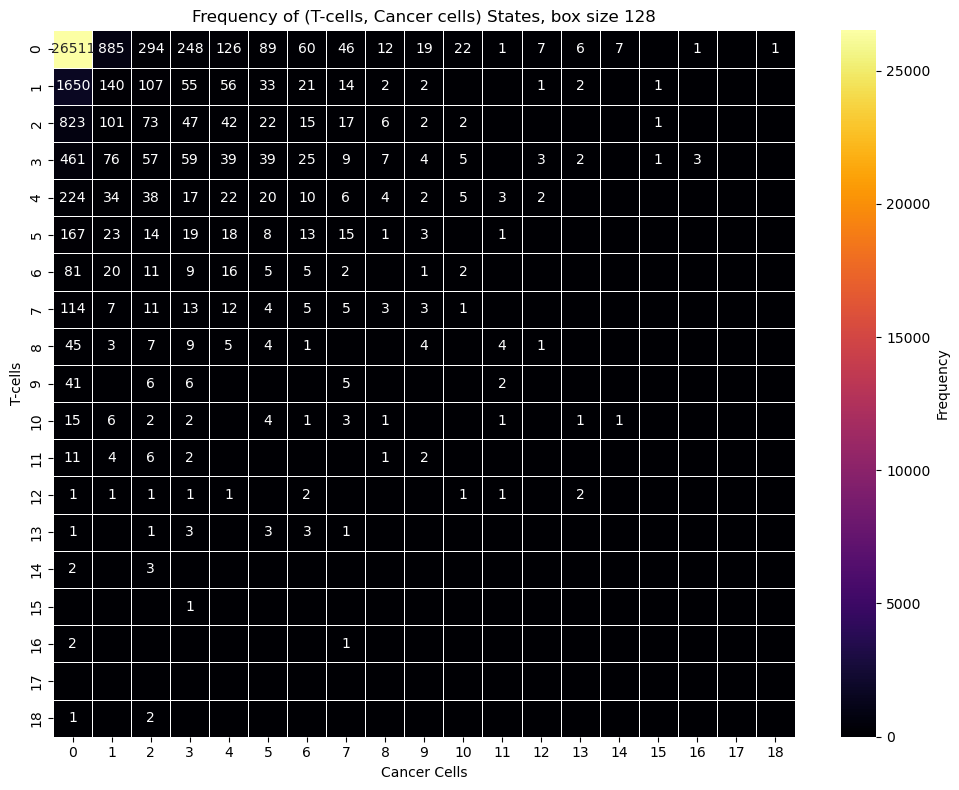

In [58]:
# Aggregate state counts
state_counts = defaultdict(int)

for frame in range(state_tensor.shape[0]):
    for box_x in range(state_tensor.shape[1]):
        for box_y in range(state_tensor.shape[2]):
            state_t = state_tensor[frame, box_x, box_y]
            t_cells = int(state_t[0])
            cancer_cells = int(state_t[1])
            state_counts[(t_cells, cancer_cells)] += 1

# Extract the maximum values for each axis to define heatmap size
max_t_cells = max(t for t, c in state_counts.keys())
max_cancer_cells = max(c for t, c in state_counts.keys())

# Initialize a 2D array (heatmap) with zeros
heatmap_data = torch.zeros((max_t_cells + 1, max_cancer_cells + 1))

# Populate the heatmap data with the counts
for (t_cells, cancer_cells), count in state_counts.items():
    heatmap_data[t_cells, cancer_cells] = count

# Convert to numpy for plotting
heatmap_data = heatmap_data.numpy()

annot = np.where(heatmap_data != 0, heatmap_data.astype(int).astype(str), '')

# Plotting the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    heatmap_data,
    cmap='inferno',
    linewidths=0.5,
    annot=annot,     # Already a string array
    fmt='',          # Remove formatting (we supply pre-formatted strings)
    cbar_kws={'label': 'Frequency'}
)

plt.title(f'Frequency of (T-cells, Cancer cells) States, box size {box_size}')
plt.xlabel('Cancer Cells')
plt.ylabel('T-cells')
plt.tight_layout()
plt.show()


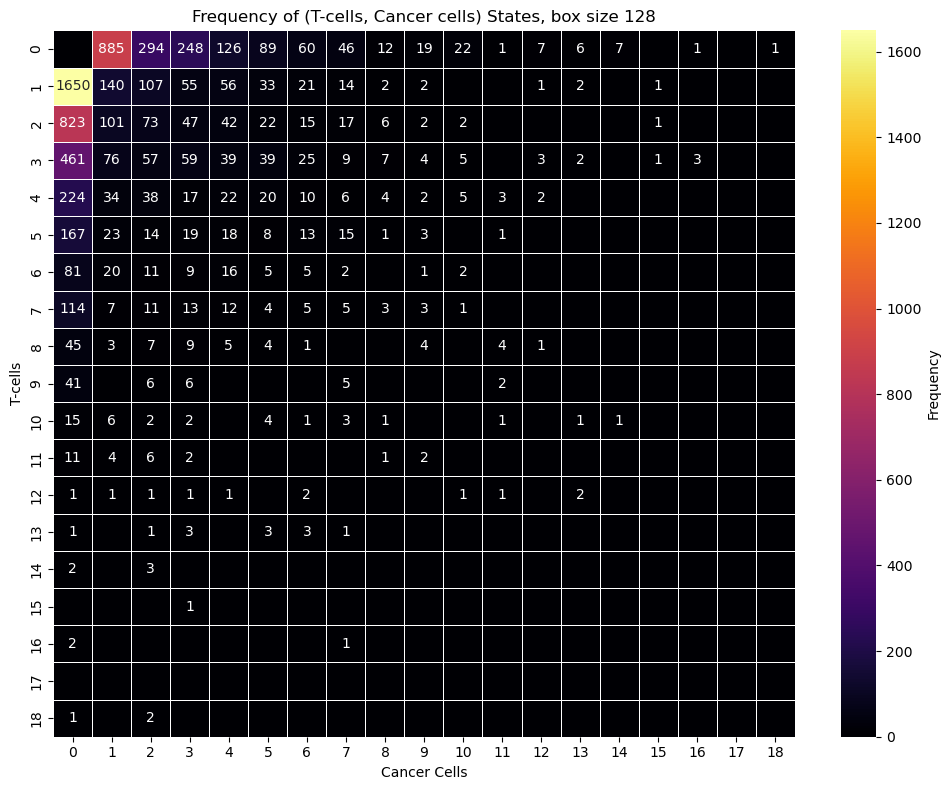

In [59]:
# Filtered state_counts (excluding (0, 0))
filtered_state_counts = {k: v for k, v in state_counts.items() if k != (0, 0)}

# Extract new max values
max_t_filtered = max(t for t, c in filtered_state_counts.keys())
max_c_filtered = max(c for t, c in filtered_state_counts.keys())

# Create filtered heatmap
heatmap_data_filtered = torch.zeros((max_t_filtered + 1, max_c_filtered + 1))

# Populate with filtered data
for (t_cells, cancer_cells), count in filtered_state_counts.items():
    heatmap_data_filtered[t_cells, cancer_cells] = count

# Convert to numpy
heatmap_data_filtered = heatmap_data_filtered.numpy()

annot = np.where(heatmap_data_filtered != 0, heatmap_data_filtered.astype(int).astype(str), '')

# Plotting the filtered heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    heatmap_data_filtered,
    cmap='inferno',
    linewidths=0.5,
    annot=annot,     # Already a string array
    fmt='',          # Remove formatting (we supply pre-formatted strings)
    cbar_kws={'label': 'Frequency'}
)

plt.title(f'Frequency of (T-cells, Cancer cells) States, box size {box_size}')
plt.xlabel('Cancer Cells')
plt.ylabel('T-cells')
plt.tight_layout()
plt.show()


## Creation of the markov transition matrix (counts and normalized)

In [4]:
# The markov transition tnsor stores the states of each box
# 1st dimension: frame number
# 2nd dimension: x position of the box in the image
# 3rd dimension: y position of the box in the image
# 4th dimension: state values (e.g., T-cells and cancer cells) (τ, κ) at t
# 5th dimension: state values (e.g., T-cells and cancer cells) (τ, κ) at t+1

markov_transition_tensor = torch.zeros(all_cells_tensor.shape[2]-1,
                                image_width // box_size,
                                image_height // box_size,
                                len(unique_states),
                                len(unique_states))

# For loop to fill in the transition matrix with all the states
for frame in range(all_cells_tensor.shape[2]-1):
    for box_x in range(image_width // box_size):
        for box_y in range(image_height // box_size):
            state_t = tuple(state_tensor[frame, box_x, box_y].tolist())
            state_t_plus_1 = tuple(state_tensor[frame + 1, box_x, box_y].tolist())

            state_t_index = state_to_index[state_t]
            state_t_plus_1_index = state_to_index[state_t_plus_1]

            if frame ==0:
                markov_transition_tensor[frame, box_x, box_y, state_t_index, state_t_plus_1_index] += 1
            else:
                markov_transition_tensor[frame, box_x, box_y] = markov_transition_tensor[frame-1, box_x, box_y].clone()
                markov_transition_tensor[frame, box_x, box_y, state_t_index, state_t_plus_1_index] += 1

# Create a seperate normalized matrix to seperate for counts
normalized_markov_transition_tensor = markov_transition_tensor.clone().float()

# For loop to normalize the transition matrix
for frame in range(all_cells_tensor.shape[2]-1):
    for box_x in range(image_width // box_size):
        for box_y in range(image_height // box_size):
            row_sums = normalized_markov_transition_tensor[frame, box_x, box_y].sum(dim=1)

            # Avoid division by 0, 0/1=0 so will still create proper matrix
            row_sums[row_sums == 0] = 1

            normalized_markov_transition_tensor[frame, box_x, box_y] = normalized_markov_transition_tensor[frame, box_x, box_y]/row_sums.unsqueeze(1)

total_possible_transitions = (image_width // box_size) * (image_height // box_size) * (all_cells_tensor.shape[2] - 1)

## Recruitment

### Creation of the recruitment tensor

In [42]:
# The recruitment tensor stores the recruitment count at t for cancer and immune cells
# 1st dimension: frame number
# 2nd dimension: x position of the box in the image
# 3rd dimension: y position of the box in the image
# 4th dimension: number of time a recruitment took place at t

recruitment_count_tensor = torch.zeros(all_cells_tensor.shape[2]-1,
                                image_width // box_size,
                                image_height // box_size,
                                2) # 0 = # cancer cells recruited, 1 = # immune cells recruited

# The movement tensor stores the movement count at t for cancer and immune cells
# 1st dimension: frame number
# 2nd dimension: x position of the box in the image
# 3rd dimension: y position of the box in the image
# 4th dimension: number of time a movement took place at t

movement_tensor = torch.zeros(all_cells_tensor.shape[2]-1,
                                image_width // box_size,
                                image_height // box_size,
                                2) # 0 = # cancer cells moved to that space, 1 = # immune cells moved to that space

# The movement tensor stores the movement count at t for cancer and immune cells
# 1st dimension: frame number
# 2nd dimension: x position of the box in the image
# 3rd dimension: y position of the box in the image
# 4th dimension: number of time a detatchment took place at t

detatchment_tensor = torch.zeros(all_cells_tensor.shape[2]-1,
                                image_width // box_size,
                                image_height // box_size,
                                2) # 0 = # cancer cells detatched, 1 = # immune cells detatched

for frame in range(all_cells_tensor.shape[2]-1):
    for box_x in range(image_width // box_size):
        for box_y in range(image_height // box_size):
            # Only compare t with t+1
            if frame == 0:
                continue
            
            # grabbing the state at t and t+1
            tau_t, kappa_t = state_tensor[frame -1, box_x, box_y].tolist()
            tau_t_plus_1, kappa_t_plus_1 = state_tensor[frame, box_x, box_y].tolist()

            # grabbing the x,y coordinates at t and t+1 with their cell types
            x_coord_t = all_cells_tensor[x_tensor_pos, :, frame - 1]    
            y_coord_t = all_cells_tensor[y_tensor_pos, :, frame - 1]
            cell_type_t = all_cells_tensor[cell_type_tensor_pos, :, frame - 1]

            x_coord_t_plus_1 = all_cells_tensor[x_tensor_pos, :, frame]
            y_coord_t_plus_1 = all_cells_tensor[y_tensor_pos, :, frame]

            box_x_indices_t, box_y_indices_t = get_box_index_tensor(x_coord_t, y_coord_t, box_size, image_width, image_height)
            box_x_indices_t_plus_1, box_y_indices_t_plus_1 = get_box_index_tensor(x_coord_t_plus_1, y_coord_t_plus_1, box_size, image_width, image_height)

            # Filter the cells that belong to the target box at time t and t+1
            cells_in_box_t = (box_x_indices_t == box_x) & (box_y_indices_t == box_y)
            cells_in_box_t_plus_1 = (box_x_indices_t_plus_1 == box_x) & (box_y_indices_t_plus_1 == box_y)
            cells_that_exist_at_t = (x_coord_t != 0) & (y_coord_t !=0)
            cells_not_in_box_at_t = ~cells_in_box_t

            cells_that_moved_to_new_box = cells_that_exist_at_t & cells_in_box_t_plus_1 & cells_not_in_box_at_t
            movement_tensor[frame, box_x, box_y, 0] = torch.sum(cells_that_moved_to_new_box & (cell_type_t == 2))
            movement_tensor[frame, box_x, box_y, 1] = torch.sum(cells_that_moved_to_new_box & (cell_type_t == 3))

            # Detatchment condition:
            # if 

            # Recruitment condition:
            # 1. Tau (T-cells) increased from t to t+1 (tau_t_plus_1 > tau_t)
            # 2. There is at least one cancer cell (kappa_t >= 1) at t
            # 3. There is at least one cancer cell at t+1 (kappa_t_plus_1 >= 1)
            if tau_t_plus_1 > tau_t and kappa_t >= 1 and kappa_t_plus_1 >= 1:

                # Now getting the cells that
                # 1. Exist at t
                # 2. It is in the box at t+1
                # 3. It is not the same t-cell at t
                recruited_cells_at_t_plus_1 = cells_that_exist_at_t & cells_in_box_t_plus_1 & cells_not_in_box_at_t

                # Adding the cancer and immune cells that are recruited to each other when at least 1 immune cell is present and 1 cancer cell
                recruitment_count_tensor[frame, box_x, box_y, 0] = torch.sum(recruited_cells_at_t_plus_1 & (cell_type_t == 2))
                recruitment_count_tensor[frame, box_x, box_y, 1] = torch.sum(recruited_cells_at_t_plus_1 & (cell_type_t == 3))
            


## Plotting over time

### cell count

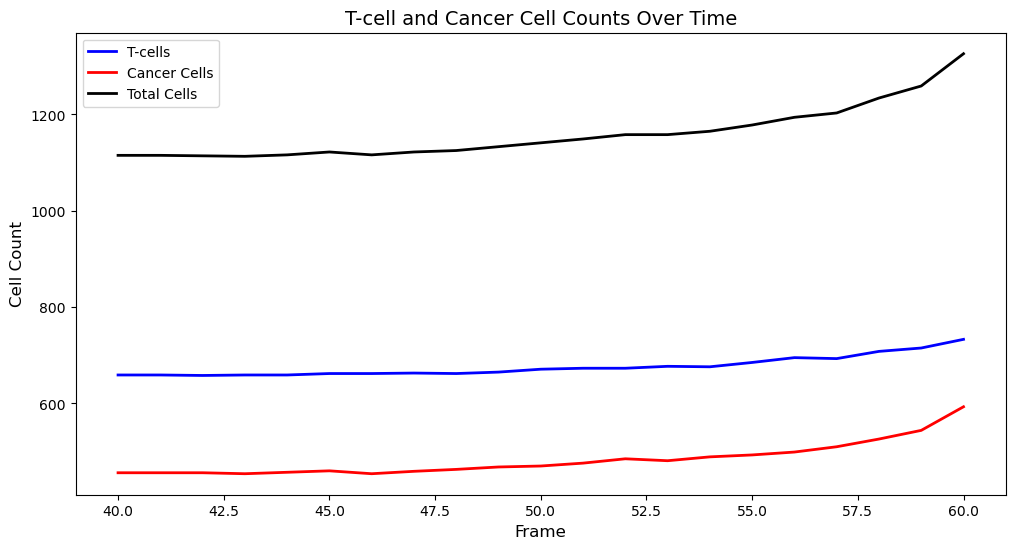

In [13]:
immune_cell_counts = []
cancer_cell_counts = []
total_cell_counts = []

for frame in range(all_cells_tensor.shape[2]):
    x_coord_t = all_cells_tensor[x_tensor_pos, :, frame]
    y_coord_t = all_cells_tensor[y_tensor_pos, :, frame]
    cell_types_at_frame = all_cells_tensor[cell_type_tensor_pos, :, frame]

    cells_that_exist_at_t = (x_coord_t != 0) & (y_coord_t !=0)

    immune_cell_count_t = torch.sum((cell_types_at_frame == 3) & cells_that_exist_at_t)
    cancer_cell_count_t = torch.sum((cell_types_at_frame == 2) & cells_that_exist_at_t)

    immune_cell_counts.append(immune_cell_count_t)
    cancer_cell_counts.append(cancer_cell_count_t)
    total_cell_counts.append(cancer_cell_count_t + immune_cell_count_t)

# Now plot the counts over time
plt.figure(figsize=(12, 6))
x = np.linspace(40, 60, all_cells_tensor.shape[2])
plt.plot(x, immune_cell_counts, label="T-cells", color="blue", linewidth=2)
plt.plot(x, cancer_cell_counts, label="Cancer Cells", color="red", linewidth=2)
plt.plot(x, total_cell_counts, label="Total Cells", color="black", linewidth=2)

# Add labels and title
plt.xlabel("Frame", fontsize=12)
plt.ylabel("Cell Count", fontsize=12)
plt.title("T-cell and Cancer Cell Counts Over Time", fontsize=14)
plt.legend()

# Show the plot
plt.show()

### recruitment over time

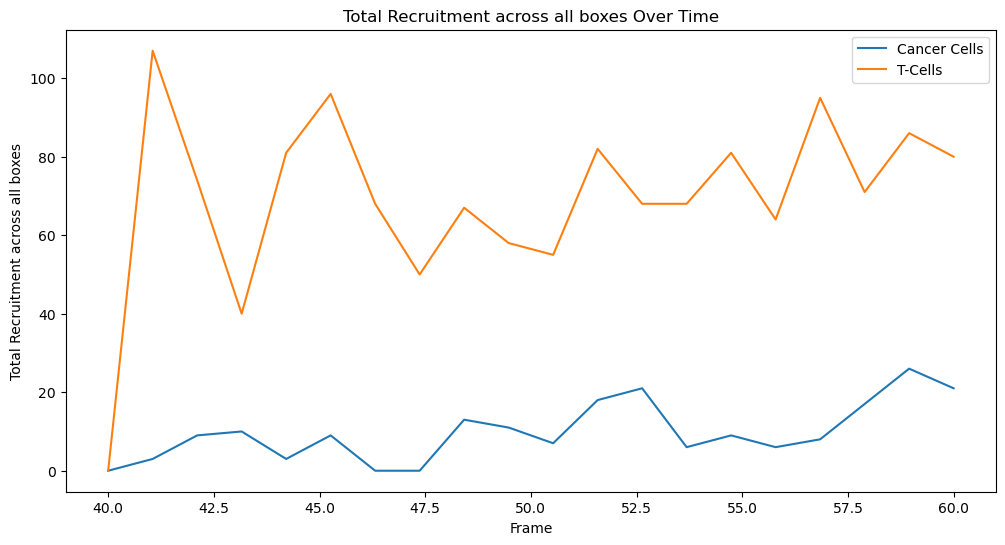

In [19]:
total_recruitment_cancer = []
total_recruitment_immune = []

for frame in range(recruitment_count_tensor.shape[0]):
    total_recruitment_cancer.append(recruitment_count_tensor[frame, :, :, 0].sum().item())
    total_recruitment_immune.append(recruitment_count_tensor[frame, :, :, 1].sum().item())

plt.figure(figsize=(12, 6))
x = np.linspace(40, 60, all_cells_tensor.shape[2]-1)
plt.plot(x, total_recruitment_cancer, label="Cancer Cells")
plt.plot(x, total_recruitment_immune, label="T-Cells")
plt.xlabel("Frame")
plt.ylabel("Total Recruitment across all boxes")
plt.legend()
plt.title("Total Recruitment across all boxes Over Time")
plt.show()

## Visualizing box space

### heatmap video counts with overlay

In [7]:
# Settings
base_wl = r"\\store\department\gene\chien_data\Lab\Data_and_Analysis\Tsai-Ying_Chen\TYC070_EC546_TILs_72hr_20250328\72hr_recording_20250328at132435\WhiteLight"
base_wl_seg = r"\\store\department\gene\chien_data\Lab\Data_and_Analysis\Tsai-Ying_Chen\TYC070_EC546_TILs_72hr_20250328\72hr_recording_20250328at132435\Whitelight_SC_clusters_cellpose"
base_membrane_seg = r"\\store\department\gene\chien_data\Lab\Data_and_Analysis\Tsai-Ying_Chen\TYC070_EC546_TILs_72hr_20250328\72hr_recording_20250328at132435\460nm_SC_cellpose"
output_path = r"\\store\department\gene\chien_data\Lab\Data_and_Analysis\Tsai-Ying_Chen\TYC070_EC546_TILs_72hr_20250328\72hr_recording_20250328at132435\results_frames_0_60_Wilco\tracking_results_from_Wilco_Segm\recruitment_immune_heatmap_counts_segm_32.mp4"
fps = 5
heatmap_shape = recruitment_count_tensor.shape[1:3]  # (Y, X) grid size of the boxes
roi = 17
roi_str = f"ROI{roi}"

# Video writer for full-res output
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
video_writer = cv2.VideoWriter(output_path, fourcc, fps, (image_width, image_height))

# Normalize heatmap values across all timepoints
max_val = recruitment_count_tensor[:, :, :, 0].max().item()


# Loop through each timepoint
for frame_idx in range(recruitment_count_tensor.shape[0]):
    heatmap_data = recruitment_count_tensor[frame_idx, :, :, 1].cpu().numpy()

    # Load the full-res original image (grayscale)
    wl_fname = f"72hr_recording_WL_1ms_WhiteLight_frame{frame_idx:05d}_{roi_str}.tif"
    wl_path = os.path.join(base_wl_seg, wl_fname)

    membrane_fname = f"72hr_recording_50B_2000ms_frame{frame_idx:05d}_{roi_str}.tif"
    membrane_path = os.path.join(base_membrane_seg, membrane_fname)

    original_frame = cv2.imread(membrane_path, -1)  # shape (5120, 5120)

    # Scale the original image to uint8
    frame_max = original_frame.max()
    if frame_max == 0:
        frame_max = 1  # avoid division by zero
    original_uint8 = cv2.convertScaleAbs(original_frame, alpha=(255.0 / frame_max))
    original_bgr = cv2.cvtColor(original_uint8, cv2.COLOR_GRAY2BGR)

    # Prepare overlay copy
    overlayed = original_bgr.copy()

    # Use colormap for heatmap
    colormap = plt.get_cmap('inferno')
    alpha = 0.6  # Transparency of the overlay

    # Loop over heatmap grid and blend only non-zero cells
    for i in range(heatmap_shape[1]):  # X axis
        for j in range(heatmap_shape[0]):  # Y axis
            value = heatmap_data[j, i]
            if value == 0:
                continue

            # Normalize and map value to color
            rgba = colormap(value / max_val)
            r, g, b = int(rgba[0] * 255), int(rgba[1] * 255), int(rgba[2] * 255)

            # Determine cell region
            top_left = (i * box_size, j * box_size)
            bottom_right = ((i + 1) * box_size, (j + 1) * box_size)

            # Extract the corresponding region
            region = overlayed[top_left[1]:bottom_right[1], top_left[0]:bottom_right[0]]
            color_overlay = np.full_like(region, (b, g, r))

            # Blend only the region
            blended = cv2.addWeighted(region, 1 - alpha, color_overlay, alpha, 0)
            overlayed[top_left[1]:bottom_right[1], top_left[0]:bottom_right[0]] = blended

    # Optional: apply post-enhancement (increase contrast/brightness slightly)
    overlayed = cv2.convertScaleAbs(overlayed, alpha=1.2, beta=10)

    # Write the frame
    video_writer.write(overlayed)

# Finalize video
video_writer.release()
print(f"Video saved to: {output_path}")

Video saved to: \\store\department\gene\chien_data\Lab\Data_and_Analysis\Tsai-Ying_Chen\TYC070_EC546_TILs_72hr_20250328\72hr_recording_20250328at132435\results_frames_0_60_Wilco\tracking_results_from_Wilco_Segm\recruitment_immune_heatmap_counts_segm_32.mp4


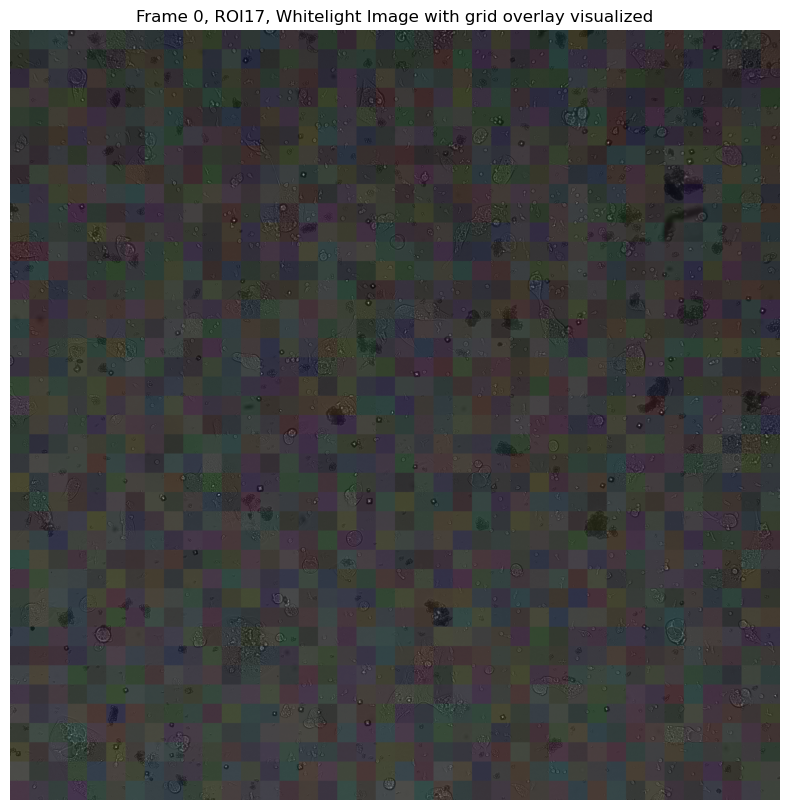

In [12]:
# Settings (make sure box_size is defined)
frame_idx = 0
alpha = 0.1
np.random.seed(42)  # For consistent random colors

# Load membrane image (grayscale)
wl_fname = f"72hr_recording_WL_1ms_WhiteLight_frame{frame_idx:05d}_{roi_str}.tif"
wl_path = os.path.join(base_wl, wl_fname)
original_frame = cv2.imread(wl_path, -1)

# Normalize to uint8
frame_max = original_frame.max() or 1
original_uint8 = cv2.convertScaleAbs(original_frame, alpha=(255.0 / frame_max))
original_bgr = cv2.cvtColor(original_uint8, cv2.COLOR_GRAY2BGR)
overlayed = original_bgr.copy()

# Overlay random colors in grid
for i in range(heatmap_shape[1]):  # X
    for j in range(heatmap_shape[0]):  # Y
        color = np.random.randint(0, 256, size=3)
        top_left = (i * box_size, j * box_size)
        bottom_right = ((i + 1) * box_size, (j + 1) * box_size)

        region = overlayed[top_left[1]:bottom_right[1], top_left[0]:bottom_right[0]]
        color_overlay = np.full_like(region, color)
        blended = cv2.addWeighted(region, 1 - alpha, color_overlay, alpha, 0)
        overlayed[top_left[1]:bottom_right[1], top_left[0]:bottom_right[0]] = blended

# Display with matplotlib
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(overlayed, cv2.COLOR_BGR2RGB))
plt.title("Frame 0, ROI17, Whitelight Image with grid overlay visualized")
plt.axis("off")
plt.show()

### heatmap video counts seaborn

In [23]:
# Settings
output_path = r"\\store\department\gene\chien_data\Lab\Data_and_Analysis\Tsai-Ying_Chen\TYC070_EC546_TILs_72hr_20250328\72hr_recording_20250328at132435\results_frames_0_60_Wilco\tracking_results_from_Wilco_Segm\recruitment_immune_heatmap_counts_seaborn_32.mp4"
fps = 5
cell_type = 1
heatmap_shape = recruitment_count_tensor.shape[1:3]  # (Y, X)
max_count_cancer = recruitment_count_tensor[:, :, :, cell_type].max().item()

# Create a dummy figure to determine size
fig, ax = plt.subplots(figsize=(10, 8), dpi=100)
canvas = FigureCanvas(fig)
plt.close(fig)

# Get canvas size
width, height = int(canvas.get_width_height()[0]), int(canvas.get_width_height()[1])
video_writer = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))

# Loop through each frame
for frame_idx in range(recruitment_count_tensor.shape[0]):
    heatmap_data = recruitment_count_tensor[frame_idx, :, :, cell_type].cpu().numpy()

    # Create heatmap figure
    fig, ax = plt.subplots(figsize=(10, 8), dpi=100)
    sns.heatmap(
        heatmap_data,
        annot=False,
        cmap='inferno',
        cbar=True,
        vmin=0,
        vmax=max_count_cancer
    )
    ax.set_title(f"Immune Cell Recruitment Heatmap - Frame {frame_idx}")
    ax.set_xlabel("Box X Position")
    ax.set_ylabel("Box Y Position")

    # Render the figure to a canvas and convert to image
    canvas = FigureCanvas(fig)
    canvas.draw()
    img = np.frombuffer(canvas.buffer_rgba(), dtype=np.uint8)
    img = img.reshape((int(canvas.get_width_height()[1]), int(canvas.get_width_height()[0]), 4))
    img_bgr = cv2.cvtColor(img, cv2.COLOR_RGBA2BGR)
    plt.close(fig)

    # Write frame to video
    video_writer.write(img_bgr)

# Finalize
video_writer.release()
print(f"Heatmap video saved to: {output_path}")

Heatmap video saved to: \\store\department\gene\chien_data\Lab\Data_and_Analysis\Tsai-Ying_Chen\TYC070_EC546_TILs_72hr_20250328\72hr_recording_20250328at132435\results_frames_0_60_Wilco\tracking_results_from_Wilco_Segm\recruitment_immune_heatmap_counts_seaborn_32.mp4


### cumulative sum

In [ ]:
# Compute cumulative sum along the time axis (dim=0)
cell_type = 1
cumulative_tensor = torch.cumsum(movement_tensor[:, :, :, cell_type], dim=0)

# Get the max value for consistent color scaling across frames
max_cumulative_count = cumulative_tensor.max().item()

# Settings
output_path = r"\\store\department\gene\chien_data\Lab\Data_and_Analysis\Tsai-Ying_Chen\TYC070_EC546_TILs_72hr_20250328\72hr_recording_20250328at132435\results_frames_40_60_Wilco\tb_copy_for_path\movement_immune_heatmap_counts_seaborn_cum_128.mp4"
fps = 5
heatmap_shape = cumulative_tensor.shape[1:3]  # (Y, X)

# Create a dummy figure to determine size
fig, ax = plt.subplots(figsize=(10, 8), dpi=100)
canvas = FigureCanvas(fig)
plt.close(fig)

# Get canvas size
width, height = int(canvas.get_width_height()[0]), int(canvas.get_width_height()[1])
video_writer = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))

# Loop through each frame
for frame_idx in range(cumulative_tensor.shape[0]):
    heatmap_data = cumulative_tensor[frame_idx].cpu().numpy()

    # Create heatmap figure
    fig, ax = plt.subplots(figsize=(10, 8), dpi=100)
    sns.heatmap(
        heatmap_data,
        annot=False,
        cmap='inferno',
        cbar=True,
        vmin=0,
        vmax=max_cumulative_count
    )
    ax.set_title(f"Cumulative Immune Cell Movement - Frame {frame_idx + 41}")
    ax.set_xlabel("Box X Position")
    ax.set_ylabel("Box Y Position")

    # Render to RGBA
    canvas = FigureCanvas(fig)
    canvas.draw()
    img = np.frombuffer(canvas.buffer_rgba(), dtype=np.uint8)
    img = img.reshape((int(canvas.get_width_height()[1]), int(canvas.get_width_height()[0]), 4))
    img_bgr = cv2.cvtColor(img, cv2.COLOR_RGBA2BGR)
    plt.close(fig)

    # Write frame to video
    video_writer.write(img_bgr)

# Finalize
video_writer.release()
print(f"Cumulative heatmap video saved to: {output_path}")

#### cumulative sum video

In [53]:
# Settings
base_wl = r"\\store\department\gene\chien_data\Lab\Data_and_Analysis\Tsai-Ying_Chen\TYC070_EC546_TILs_72hr_20250328\72hr_recording_20250328at132435\WhiteLight"
base_wl_seg = r"\\store\department\gene\chien_data\Lab\Data_and_Analysis\Tsai-Ying_Chen\TYC070_EC546_TILs_72hr_20250328\72hr_recording_20250328at132435\Whitelight_SC_clusters_cellpose"
base_membrane_seg = r"\\store\department\gene\chien_data\Lab\Data_and_Analysis\Tsai-Ying_Chen\TYC070_EC546_TILs_72hr_20250328\72hr_recording_20250328at132435\460nm_SC_cellpose"
output_path = r"\\store\department\gene\chien_data\Lab\Data_and_Analysis\Tsai-Ying_Chen\TYC070_EC546_TILs_72hr_20250328\72hr_recording_20250328at132435\results_frames_0_60_Wilco\tracking_results_from_Wilco_Segm\recruitment_immune_heatmap_cumsum_wl_128.mp4"
fps = 5
heatmap_shape = recruitment_count_tensor.shape[1:3]  # (Y, X) grid size of the boxes
roi = 17
roi_str = f"ROI{roi}"

# Compute cumulative sum along the time axis (dim=0)
cell_type = 1
cumulative_tensor = torch.cumsum(movement_tensor[:, :, :, cell_type], dim=0)

# Get the max value for consistent color scaling across frames
max_cumulative_count = cumulative_tensor.max().item()

# Video writer for full-res output
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
video_writer = cv2.VideoWriter(output_path, fourcc, fps, (image_width, image_height))

# Loop through each timepoint
for frame_idx in range(cumulative_tensor.shape[0]):
    heatmap_data = cumulative_tensor[frame_idx, :, :].cpu().numpy()

    # Load the full-res original image (grayscale)
    wl_fname = f"72hr_recording_WL_1ms_WhiteLight_frame{frame_idx:05d}_{roi_str}.tif"
    wl_path = os.path.join(base_wl, wl_fname)

    membrane_fname = f"72hr_recording_50B_2000ms_frame{frame_idx:05d}_{roi_str}.tif"
    membrane_path = os.path.join(base_membrane_seg, membrane_fname)

    original_frame = cv2.imread(wl_path, -1)  # shape (5120, 5120)

    # Scale the original image to uint8
    frame_max = original_frame.max()
    if frame_max == 0:
        frame_max = 1  # avoid division by zero
    original_uint8 = cv2.convertScaleAbs(original_frame, alpha=(255.0 / frame_max))
    original_bgr = cv2.cvtColor(original_uint8, cv2.COLOR_GRAY2BGR)

    # Prepare overlay copy
    overlayed = original_bgr.copy()

    # Use colormap for heatmap
    colormap = plt.get_cmap('inferno')
    alpha = 0.6  # Transparency of the overlay

    # Loop over heatmap grid and blend only non-zero cells
    for i in range(heatmap_shape[1]):  # X axis
        for j in range(heatmap_shape[0]):  # Y axis
            value = heatmap_data[j, i]
            if value == 0:
                continue

            # Normalize and map value to color
            rgba = colormap(value / max_cumulative_count)
            r, g, b = int(rgba[0] * 255), int(rgba[1] * 255), int(rgba[2] * 255)

            # Determine cell region
            top_left = (i * box_size, j * box_size)
            bottom_right = ((i + 1) * box_size, (j + 1) * box_size)

            # Extract the corresponding region
            region = overlayed[top_left[1]:bottom_right[1], top_left[0]:bottom_right[0]]
            color_overlay = np.full_like(region, (b, g, r))

            # Blend only the region
            blended = cv2.addWeighted(region, 1 - alpha, color_overlay, alpha, 0)
            overlayed[top_left[1]:bottom_right[1], top_left[0]:bottom_right[0]] = blended

    # Optional: apply post-enhancement (increase contrast/brightness slightly)
    overlayed = cv2.convertScaleAbs(overlayed, alpha=1.2, beta=10)

    # Write the frame
    video_writer.write(overlayed)

# Finalize video
video_writer.release()
print(f"Video saved to: {output_path}")

Video saved to: \\store\department\gene\chien_data\Lab\Data_and_Analysis\Tsai-Ying_Chen\TYC070_EC546_TILs_72hr_20250328\72hr_recording_20250328at132435\results_frames_0_60_Wilco\tracking_results_from_Wilco_Segm\recruitment_immune_heatmap_cumsum_wl_128.mp4


#### cumulative sum heatmap last frame

Text(95.72222222222221, 0.5, 'Box Y Position')

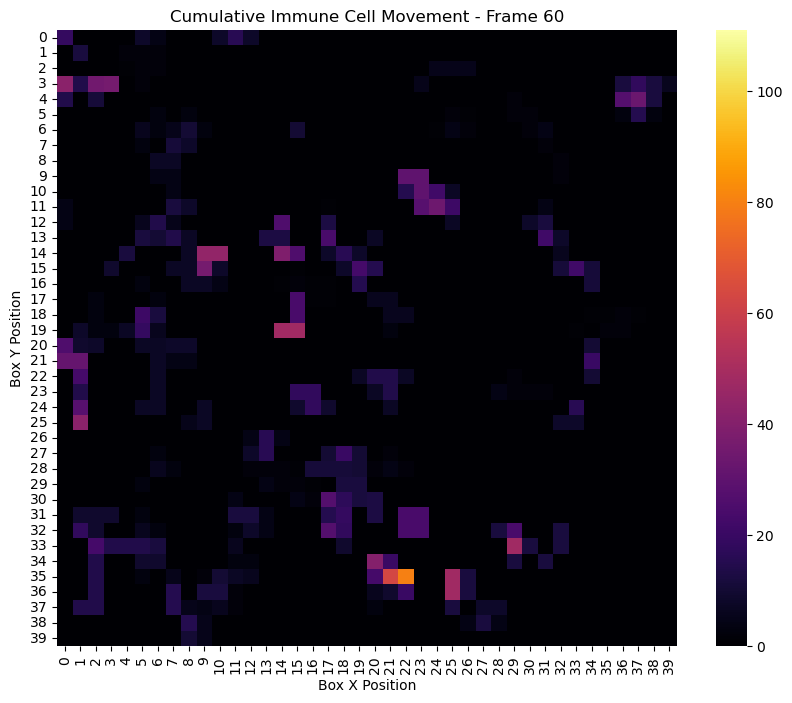

In [20]:
# Compute cumulative sum along the time axis (dim=0)
cell_type = 1
frame_idx = 59
cumulative_tensor = torch.cumsum(movement_tensor[:, :, :, cell_type], dim=0)

# Get the max value for consistent color scaling across frames
max_cumulative_count = cumulative_tensor.max().item()

heatmap_data = cumulative_tensor[frame_idx -41].cpu().numpy()

# Create heatmap figure
fig, ax = plt.subplots(figsize=(10, 8), dpi=100)
sns.heatmap(
    heatmap_data,
    annot=False,
    cmap='inferno',
    cbar=True,
    vmin=0,
    vmax=max_cumulative_count
)
ax.set_title(f"Cumulative Immune Cell Movement - Frame {frame_idx + 1}")
ax.set_xlabel("Box X Position")
ax.set_ylabel("Box Y Position")

### Death spaces


In [54]:
death_coordinates_csv = r"\\store\department\gene\chien_data\Lab\Data_and_Analysis\Tsai-Ying_Chen\TYC070_EC546_TILs_72hr_20250328\72hr_recording_20250328at132435\results_frames_40_60_Wilco\tb_dead_cell_coordinates_ROI17_ImageJ.csv"

with open(death_coordinates_csv, newline='') as csvfile:
    reader = csv.reader(csvfile)
    next(reader)

    # Extract only x and y (columns 1 and 2)
    data = [list(map(float, row[1:3])) for row in reader]
    print(data)

    # Convert to a tensor
    death_coordinates_tensor = torch.tensor(data, dtype=torch.float32)


[[72.0, 1474.0], [102.0, 2161.0], [106.0, 2121.0], [120.0, 3093.0], [202.0, 3215.0], [253.0, 3226.0], [258.0, 3267.0], [289.0, 3276.0], [312.0, 3248.0], [320.0, 3168.0], [334.0, 3935.0], [343.0, 3243.0], [369.0, 4021.0], [373.0, 1354.0], [383.0, 3874.0], [384.0, 3233.0], [463.0, 150.0], [496.0, 3917.0], [515.0, 156.0], [519.0, 3923.0], [520.0, 723.0], [529.0, 3929.0], [537.0, 3956.0], [561.0, 3932.0], [628.0, 207.0], [631.0, 2006.0], [648.0, 1917.0], [659.0, 191.0], [672.0, 1472.0], [689.0, 4923.0], [695.0, 103.0], [717.0, 1642.0], [723.0, 44.0], [728.0, 1511.0], [749.0, 3163.0], [758.0, 4066.0], [769.0, 3167.0], [783.0, 1840.0], [794.0, 3316.0], [812.0, 3285.0], [813.0, 3307.0], [814.0, 3230.0], [822.0, 3787.0], [865.0, 230.0], [898.0, 886.0], [914.0, 845.0], [1028.0, 3389.0], [1074.0, 2976.0], [1094.0, 3013.0], [1106.0, 4837.0], [1107.0, 4793.0], [1116.0, 892.0], [1137.0, 4922.0], [1162.0, 3217.0], [1216.0, 4036.0], [1355.0, 2838.0], [1362.0, 4214.0], [1366.0, 4075.0], [1394.0, 4069.

In [56]:
# Initialize the 40x40 matrix
matrix = torch.zeros((image_height // box_size, image_width // box_size), dtype=torch.int32)

# Split x and y coordinates
x_coords = death_coordinates_tensor[:, 0]
y_coords = death_coordinates_tensor[:, 1]

# Get box indices
box_x, box_y = get_box_index_tensor(x_coords, y_coords, box_size, image_width, image_height)

# Populate matrix by counting how many coordinates fall into each box
for x_idx, y_idx in zip(box_x, box_y):
    matrix[y_idx, x_idx] += 1  # Row = y, Col = x

Text(95.72222222222221, 0.5, 'Box Y Position')

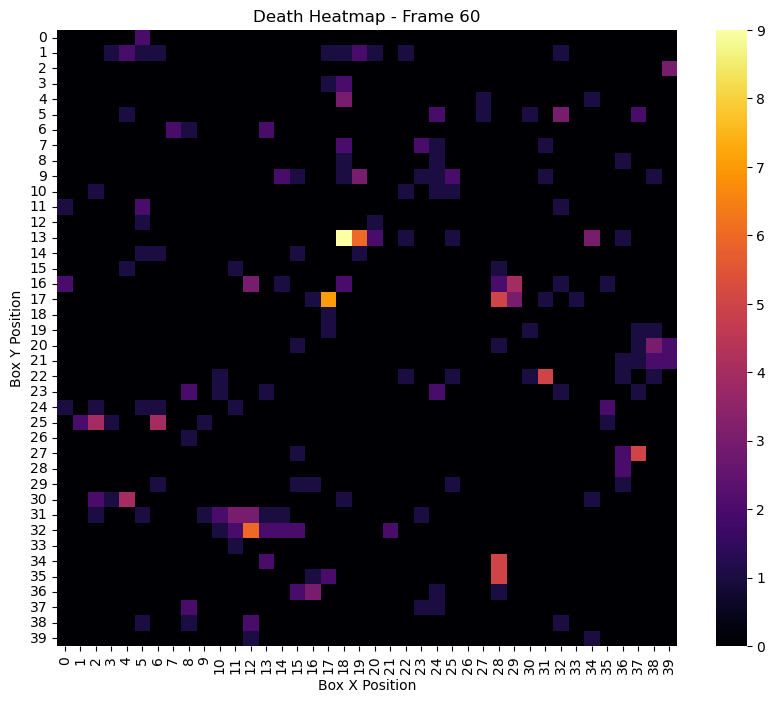

In [58]:
fig, ax = plt.subplots(figsize=(10, 8), dpi=100)
max_death_count = matrix.max()
sns.heatmap(
    matrix.numpy(),
    annot=False,
    cmap='inferno',
    cbar=True,
    vmin=0,
    vmax=max_death_count
)
ax.set_title(f"Death Heatmap - Frame {60}")
ax.set_xlabel("Box X Position")
ax.set_ylabel("Box Y Position")

## Recruitment death linking

In [45]:
# For the recruitment interaction death its hard to put it in one tensor or matrix so everyone is a sub matrix
# Each row will be the cell id
# 1. matrix with the frames that a cancer cell recruitment event happend to the cell
# 2. matrix with the frames that interaction between the cancer cell and a immune cell happend
# 3. matrix with the info if and when the cancer cell died, (e.g. non zero value 0= didn't die)
# 4. matrix with the difference between recruitment and interaction

death_time_tensor_pos = feature_name_list.index("tb_cell_death_time_ROI17")
interaction_tensor_pos = feature_name_list.index("tb_tumor_meets_immune_ROI17")

recruitment_frames_list = [[] for _ in range(all_cells_tensor.shape[1])]
interaction_frames_list = [[] for _ in range(all_cells_tensor.shape[1])]
death_frame_list = all_cells_tensor[death_time_tensor_pos,:,0].tolist() # All values are copies so each frame has the same time of death
recruitment_interaction_diff_frames_list = [[] for _ in range(all_cells_tensor.shape[1])]

for cell_id in range(all_cells_tensor.shape[1]):
    # Check if cancer, 3 is immune, 2 is cancer so if 3 skip
    if all_cells_tensor[cell_type_tensor_pos, cell_id, 0] == 3:
        continue
    
    # Go through the frames of the cell and collect info
    for frame in range(frame_size-1): # Looping through frames 0 to 19 (which corresponds to frames 1 to 20)

        # Collect Recruitment info
        x = all_cells_tensor[x_tensor_pos, cell_id, frame]
        y = all_cells_tensor[y_tensor_pos, cell_id, frame]

        # Existance check
        if x == 0 and y == 0:
            continue

        box_x, box_y = get_box_index_tensor(x, y, box_size, image_width, image_height)

        if frame > 0:
            x_minus_t = all_cells_tensor[x_tensor_pos, cell_id, frame - 1]
            y_minus_t = all_cells_tensor[y_tensor_pos, cell_id, frame - 1]
            
            if x_minus_t == 0 and y_minus_t == 0:
                continue

            box_x_minus_t, box_y_minus_t = get_box_index_tensor(x_minus_t, y_minus_t, box_size, image_width, image_height)
            
            if recruitment_count_tensor[frame, box_x, box_y, 1] > 0 and box_x == box_x_minus_t and box_y == box_y_minus_t :
                recruitment_frames_list[cell_id].append(frame + 1) # Looping through frames 0 to 19 (which corresponds to frames 1 to 20)

        # Collect interaction info
        interaction_value = all_cells_tensor[interaction_tensor_pos, cell_id, frame].item()

        if interaction_value != 0:
            interaction_frames_list[cell_id].append(frame + 1)# Looping through frames 0 to 19 (which corresponds to frames 1 to 20)

# --- Difference list (only if both events occurred)
for cell_id in range(all_cells_tensor.shape[1]):
    for r_frame in recruitment_frames_list[cell_id]:
        for i_frame in interaction_frames_list[cell_id]:
            diff = r_frame - i_frame
            recruitment_interaction_diff_frames_list[cell_id].append(diff)


In [46]:
def print_list_contents(list_name, cell_id, list_of_lists):
    """Prints the contents of a specific list for a given cell_id."""
    print(f"Contents of {list_name} for cell {cell_id}: {list_of_lists[cell_id]}")

def print_all_cell_contents(list_name, list_of_lists):
    """Prints the contents of a specific list for all cells."""
    for cell_id in range(len(list_of_lists)):
        print_list_contents(list_name, cell_id, list_of_lists)

def print_frame_counts(list_name, list_of_lists):
    """Prints how many frames have been added for each cell."""
    for cell_id in range(len(list_of_lists)):
        print(f"Cell {cell_id} has {len(list_of_lists[cell_id])} frames in {list_name}.")

def check_cell_has_frames(list_name, cell_id, list_of_lists):
    """Checks if a cell has any frames in a specific list."""
    if len(list_of_lists[cell_id]) > 0:
        print(f"Cell {cell_id} has {len(list_of_lists[cell_id])} frames in {list_name}.")
    else:
        print(f"Cell {cell_id} has no frames in {list_name}.")

def print_first_n_frames(list_name, cell_id, list_of_lists, n=5):
    """Prints the first N frames in a specific list for a cell."""
    print(f"First {n} frames in {list_name} for cell {cell_id}: {list_of_lists[cell_id][:n]}")

# print_list_contents("recruitment_frames_list", 0, recruitment_frames_list[0:592])
# print_all_cell_contents("recruitment_frames_list", recruitment_frames_list[0:592])
# print_all_cell_contents("interaction_frames_list", interaction_frames_list[0:592])
# print_all_cell_contents("death_frame_list", death_frame_list[0:592])
# print_frame_counts("recruitment_frames_list", recruitment_frames_list[0:592])
# check_cell_has_frames("recruitment_frames_list", 5, recruitment_frames_list[0:592])
# print_first_n_frames("interaction_frames_list", 3, interaction_frames_list[0:592], 10)

# print_list_contents("recruitment_frames_list", 5, recruitment_frames_list[0:592])
# print_list_contents("interaction_frames_list", 5, interaction_frames_list[0:592])
# print_list_contents("death_frame_list", 5, death_frame_list[0:592])
# print_list_contents("recruitment_interaction_diff_frames_list", 5, recruitment_interaction_diff_frames_list[0:592])

print_list_contents("recruitment_frames_list", 0, recruitment_frames_list)
print_all_cell_contents("recruitment_frames_list", recruitment_frames_list)
print_all_cell_contents("interaction_frames_list", interaction_frames_list)
print_all_cell_contents("death_frame_list", death_frame_list)
print_frame_counts("recruitment_frames_list", recruitment_frames_list)
check_cell_has_frames("recruitment_frames_list", 5, recruitment_frames_list)
print_first_n_frames("interaction_frames_list", 3, interaction_frames_list, 10)

Contents of recruitment_frames_list for cell 0: [60]
Contents of recruitment_frames_list for cell 0: [60]
Contents of recruitment_frames_list for cell 1: [4, 15, 28, 45, 49, 56]
Contents of recruitment_frames_list for cell 2: [4, 15, 28, 49, 51, 56]
Contents of recruitment_frames_list for cell 3: []
Contents of recruitment_frames_list for cell 4: [60]
Contents of recruitment_frames_list for cell 5: [4, 15, 28, 45, 49, 56]
Contents of recruitment_frames_list for cell 6: []
Contents of recruitment_frames_list for cell 7: []
Contents of recruitment_frames_list for cell 8: []
Contents of recruitment_frames_list for cell 9: [4, 15, 28, 45, 49, 56]
Contents of recruitment_frames_list for cell 10: []
Contents of recruitment_frames_list for cell 11: []
Contents of recruitment_frames_list for cell 12: [28, 34, 37, 39, 50, 55]
Contents of recruitment_frames_list for cell 13: [28, 34, 37, 39, 50, 55]
Contents of recruitment_frames_list for cell 14: [36]
Contents of recruitment_frames_list for cel

In [57]:
no_interaction = sum([1 for frame in interaction_frames_list[0:593] if not frame])
print(no_interaction)
print(no_interaction/594)

185
0.3114478114478115


### Kaplan Meier curves

In [39]:
print(cancer_death_frames)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

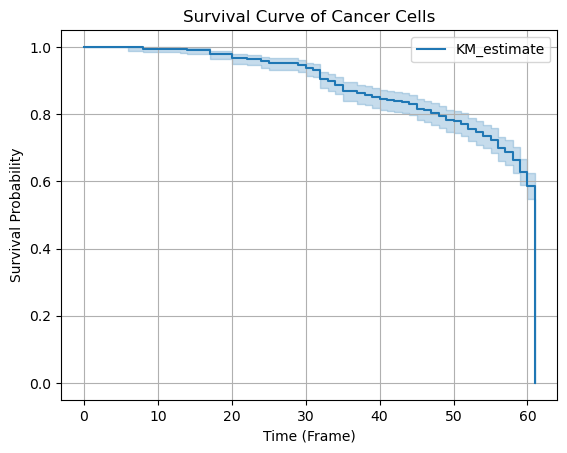

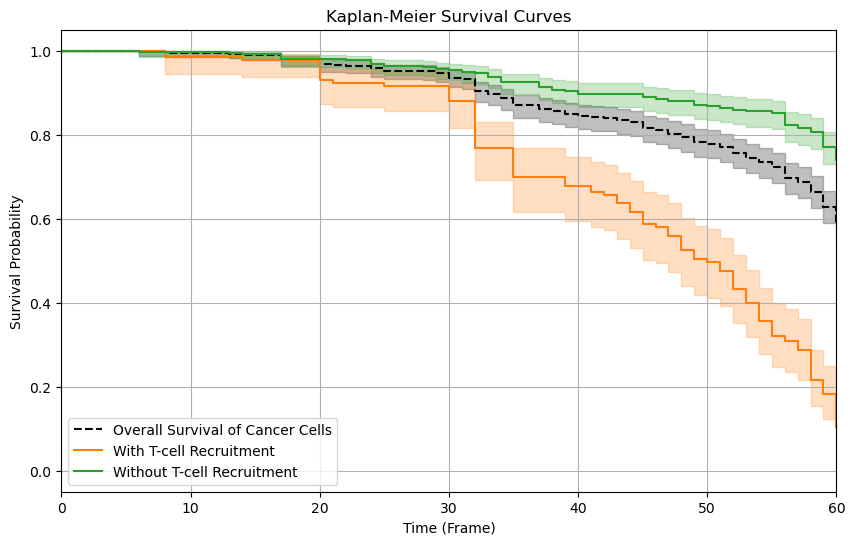

In [51]:
cell_types = all_cells_tensor[cell_type_tensor_pos, :, 0]

cancer_cells_only_boolean = (cell_types == 2)

cancer_death_frames = [frame for i, frame in enumerate(death_frame_list) if cancer_cells_only_boolean[i]]
cancer_recruitment_frames_list = [lists for i,lists in enumerate(recruitment_frames_list) if cancer_cells_only_boolean[i]]
cancer_interaction_frames_list = [lists for i,lists in enumerate(interaction_frames_list) if cancer_cells_only_boolean[i]]


censor_status_death = [1 if frame != 0 else 0 for frame in cancer_death_frames]
death_times = [frame if frame != 0 else 60 for frame in cancer_death_frames]

# Instantiate the Kaplan-Meier fitter
kmf = KaplanMeierFitter()

# Fit the data
kmf.fit(death_times, event_observed=censor_status_death)

# Plot the survival curve
fig, ax = plt.subplots()  # Define the axis object here
kmf.plot(ax=ax)

# # Adjust the x-axis to limit the frame range to 0-20
# ax.set_xlim(40, 60)

plt.title("Survival Curve of Cancer Cells")
plt.xlabel("Time (Frame)")
plt.ylabel("Survival Probability")
plt.grid(True)
plt.show()

# Recruitment vs no recruitment
recruitment_flags = [1 if any(frame <= death_frame for frame in recruitment_frames) else 0 for recruitment_frames, death_frame in zip(cancer_recruitment_frames_list, cancer_death_frames)]

# Interaction vs no interaction
interaction_flags = [1 if any(frame <= death_frame for frame in interaction_frames) else 0 for interaction_frames, death_frame in zip(cancer_interaction_frames_list, cancer_death_frames)]

# Both recruitment and interaction vs none
both_recruitment_and_interaction_flags = [1 if recruitment == 1 and interaction == 1 else 0 
                                          for recruitment, interaction in zip(recruitment_flags, interaction_flags)]

# Now we can apply the Kaplan-Meier analysis for these groups

# Prepare survival data for each group
# Recruitment vs No Recruitment:
recruitment_death_times = [death_time for death_time, recruit in zip(death_times, recruitment_flags) if recruit == 1]
recruitment_censor_status = [status for status, recruit in zip(censor_status_death, recruitment_flags) if recruit == 1]

no_recruitment_death_times = [death_time for death_time, recruit in zip(death_times, recruitment_flags) if recruit == 0]
no_recruitment_censor_status = [status for status, recruit in zip(censor_status_death, recruitment_flags) if recruit == 0]

# Interaction vs No Interaction:
interaction_death_times = [death_time for death_time, interact in zip(death_times, interaction_flags) if interact == 1]
interaction_censor_status = [status for status, interact in zip(censor_status_death, interaction_flags) if interact == 1]

no_interaction_death_times = [death_time for death_time, interact in zip(death_times, interaction_flags) if interact == 0]
no_interaction_censor_status = [status for status, interact in zip(censor_status_death, interaction_flags) if interact == 0]

# Both recruitment and interaction vs neither:
both_recruitment_and_interaction_death_times = [death_time for death_time, both in zip(death_times, both_recruitment_and_interaction_flags) if both == 1]
both_recruitment_and_interaction_censor_status = [status for status, both in zip(censor_status_death, both_recruitment_and_interaction_flags) if both == 1]

neither_recruitment_nor_interaction_death_times = [death_time for death_time, both in zip(death_times, both_recruitment_and_interaction_flags) if both == 0]
neither_recruitment_nor_interaction_censor_status = [status for status, both in zip(censor_status_death, both_recruitment_and_interaction_flags) if both == 0]

# Initialize the Kaplan-Meier Fitter
kmf = KaplanMeierFitter()

# Plot for Overall Survival of Cancer Cells
plt.figure(figsize=(10, 6))  # Create a new figure
kmf.fit(death_times, event_observed=censor_status_death)
kmf.plot(label="Overall Survival of Cancer Cells", color='black', linestyle='--')

# Plot for Recruitment vs No Recruitment
kmf.fit(recruitment_death_times, event_observed=recruitment_censor_status)
kmf.plot(label="With T-cell Recruitment")

kmf.fit(no_recruitment_death_times, event_observed=no_recruitment_censor_status)
kmf.plot(label="Without T-cell Recruitment")

# # Plot for Interaction vs No Interaction
# kmf.fit(interaction_death_times, event_observed=interaction_censor_status)
# kmf.plot(label="With Interaction", color='green')

# kmf.fit(no_interaction_death_times, event_observed=no_interaction_censor_status)
# kmf.plot(label="Without Interaction", color='orange')

# # Plot for Both Recruitment and Interaction vs Neither
# kmf.fit(both_recruitment_and_interaction_death_times, event_observed=both_recruitment_and_interaction_censor_status)
# kmf.plot(label="With Both Recruitment and Interaction", color='purple')

# kmf.fit(neither_recruitment_nor_interaction_death_times, event_observed=neither_recruitment_nor_interaction_censor_status)
# kmf.plot(label="Without Both Recruitment and Interaction", color='brown')

# Customizing the plot
plt.title("Kaplan-Meier Survival Curves")
plt.xlabel("Time (Frame)")
plt.ylabel("Survival Probability")
plt.xlim(0, 60)  
plt.grid(True)
plt.legend()
plt.show()

In [57]:
total_recruitments = sum(sum(inner) for inner in recruitment_frames_list)

print(total_recruitments)

17604


In [52]:
from lifelines.statistics import logrank_test

# Perform log-rank test for Recruitment vs No Recruitment
results_recruitment = logrank_test(recruitment_death_times, no_recruitment_death_times,
                                   event_observed_A=recruitment_censor_status, event_observed_B=no_recruitment_censor_status)

print("Log-rank test for Recruitment vs No Recruitment")
print("p-value:", results_recruitment.p_value)

# Perform log-rank test for Interaction vs No Interaction
results_interaction = logrank_test(interaction_death_times, no_interaction_death_times,
                                   event_observed_A=interaction_censor_status, event_observed_B=no_interaction_censor_status)

print("Log-rank test for Interaction vs No Interaction")
print("p-value:", results_interaction.p_value)

# Perform log-rank test for Both Recruitment and Interaction vs Neither
results_both = logrank_test(both_recruitment_and_interaction_death_times, neither_recruitment_nor_interaction_death_times,
                            event_observed_A=both_recruitment_and_interaction_censor_status, event_observed_B=neither_recruitment_nor_interaction_censor_status)

print("Log-rank test for Both Recruitment and Interaction vs Neither")
print("p-value:", results_both.p_value)


Log-rank test for Recruitment vs No Recruitment
p-value: 1.5189413118766443e-57
Log-rank test for Interaction vs No Interaction
p-value: 9.590951107209507e-62
Log-rank test for Both Recruitment and Interaction vs Neither
p-value: 1.4033384134885797e-45


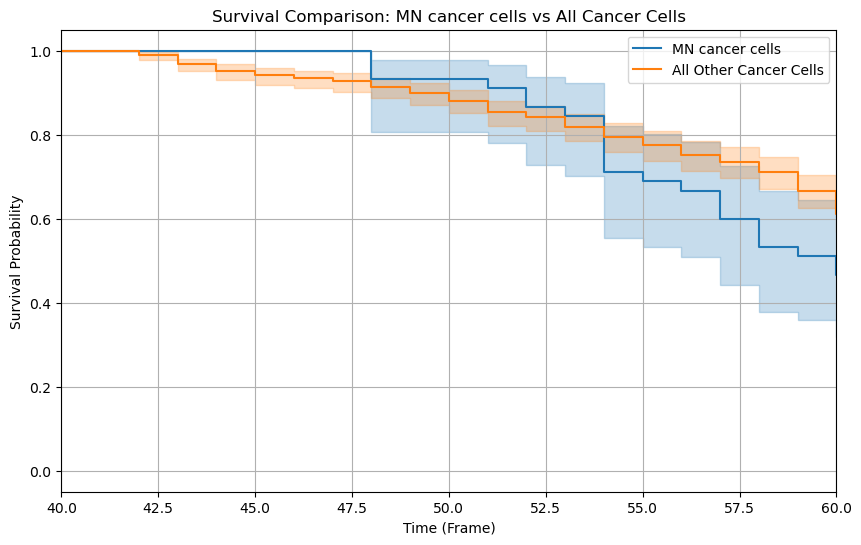

Log-rank p-value: 0.06535932595071026


In [43]:
mn_tensor_pos = feature_name_list.index("tb_MN_ROI17_new")

mn_boolean = all_cells_tensor[mn_tensor_pos, :, 0]

# Subgroup survival data
mn_death_times = [t for t, s in zip(death_times, mn_boolean) if s]
mn_censor_status = [c for c, s in zip(censor_status_death, mn_boolean) if s]

# Non-subgroup (rest of cancer cells)
rest_death_times = [t for t, s in zip(death_times, mn_boolean) if not s]
rest_censor_status = [c for c, s in zip(censor_status_death, mn_boolean) if not s]

kmf = KaplanMeierFitter()

plt.figure(figsize=(10, 6))

# Subgroup
kmf.fit(mn_death_times, event_observed=mn_censor_status, label="MN cancer cells")
kmf.plot()

# Rest
kmf.fit(rest_death_times, event_observed=rest_censor_status, label="All Other Cancer Cells")
kmf.plot()

plt.title("Survival Comparison: MN cancer cells vs All Cancer Cells")
plt.xlabel("Time (Frame)")
plt.ylabel("Survival Probability")
plt.xlim(40, 60)
plt.grid(True)
plt.legend()
plt.show()

result = logrank_test(
    mn_death_times, rest_death_times,
    event_observed_A=mn_censor_status,
    event_observed_B=rest_censor_status
)

print(f"Log-rank p-value: {result.p_value}")

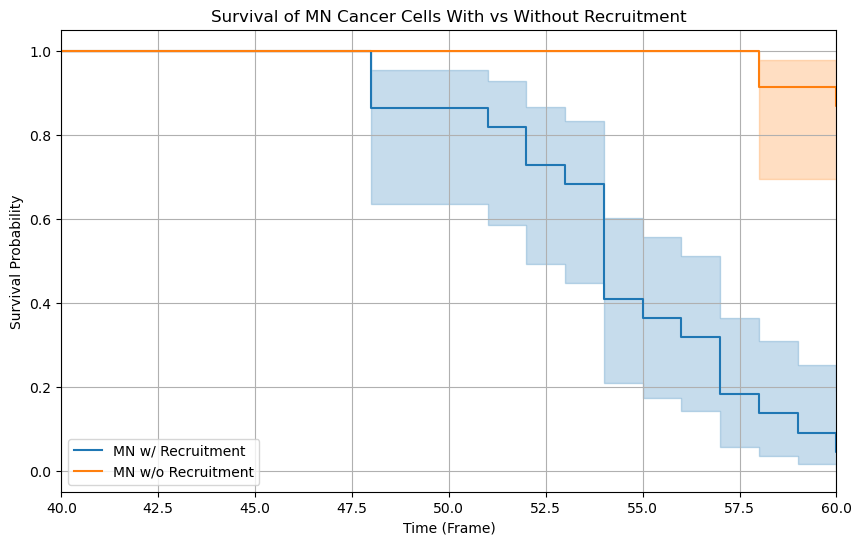

Log-rank p-value: 1.6915948052857624e-10


In [44]:
mn_recruitment_frames_list = [r for r, s in zip(cancer_recruitment_frames_list, mn_boolean) if s]
mn_death_frames = [d for d, s in zip(cancer_death_frames, mn_boolean) if s]
mn_death_times = [t for t, s in zip(death_times, mn_boolean) if s]
mn_censor_status = [c for c, s in zip(censor_status_death, mn_boolean) if s]

mn_recruitment_flags = [
    1 if any(frame <= death_frame for frame in recruit_frames) else 0
    for recruit_frames, death_frame in zip(mn_recruitment_frames_list, mn_death_frames)
]

# With recruitment
mn_with_recruitment_death_times = [t for t, flag in zip(mn_death_times, mn_recruitment_flags) if flag]
mn_with_recruitment_censor_status = [c for c, flag in zip(mn_censor_status, mn_recruitment_flags) if flag]

# Without recruitment
mn_without_recruitment_death_times = [t for t, flag in zip(mn_death_times, mn_recruitment_flags) if not flag]
mn_without_recruitment_censor_status = [c for c, flag in zip(mn_censor_status, mn_recruitment_flags) if not flag]

plt.figure(figsize=(10, 6))
kmf = KaplanMeierFitter()

kmf.fit(mn_with_recruitment_death_times, event_observed=mn_with_recruitment_censor_status, label="MN w/ Recruitment")
kmf.plot()

kmf.fit(mn_without_recruitment_death_times, event_observed=mn_without_recruitment_censor_status, label="MN w/o Recruitment")
kmf.plot()

plt.title("Survival of MN Cancer Cells With vs Without Recruitment")
plt.xlabel("Time (Frame)")
plt.ylabel("Survival Probability")
plt.xlim(40, 60)
plt.grid(True)
plt.legend()
plt.show()

result = logrank_test(
    mn_with_recruitment_death_times,
    mn_without_recruitment_death_times,
    event_observed_A=mn_with_recruitment_censor_status,
    event_observed_B=mn_without_recruitment_censor_status
)

print(f"Log-rank p-value: {result.p_value}")

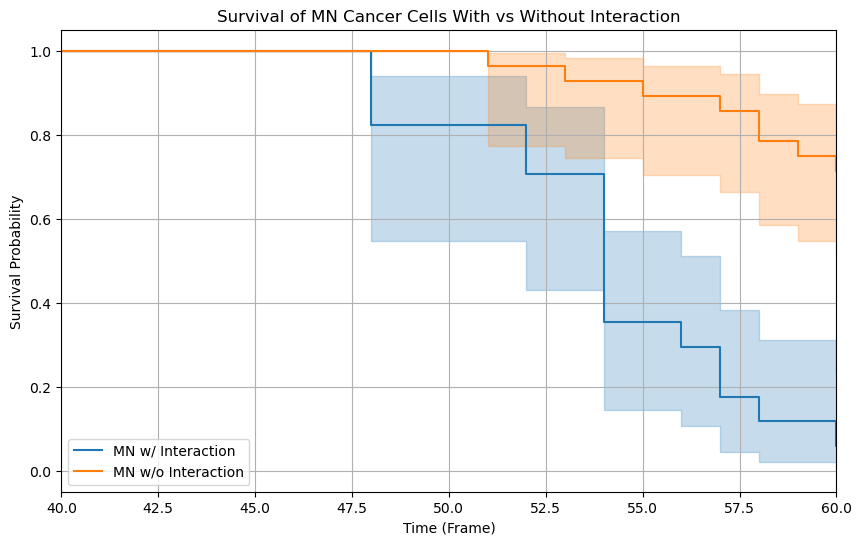

Log-rank p-value: 2.2709114486226633e-07


In [46]:
mn_interaction_frames_list = [i for i, s in zip(cancer_interaction_frames_list, mn_boolean) if s]
mn_death_frames = [d for d, s in zip(cancer_death_frames, mn_boolean) if s]  # already done earlier
mn_death_times = [t for t, s in zip(death_times, mn_boolean) if s]
mn_censor_status = [c for c, s in zip(censor_status_death, mn_boolean) if s]

mn_interaction_flags = [
    1 if any(frame <= death_frame for frame in interaction_frames) else 0
    for interaction_frames, death_frame in zip(mn_interaction_frames_list, mn_death_frames)
]

# With interaction
mn_with_interaction_death_times = [t for t, flag in zip(mn_death_times, mn_interaction_flags) if flag]
mn_with_interaction_censor_status = [c for c, flag in zip(mn_censor_status, mn_interaction_flags) if flag]

# Without interaction
mn_without_interaction_death_times = [t for t, flag in zip(mn_death_times, mn_interaction_flags) if not flag]
mn_without_interaction_censor_status = [c for c, flag in zip(mn_censor_status, mn_interaction_flags) if not flag]

plt.figure(figsize=(10, 6))
kmf = KaplanMeierFitter()

kmf.fit(mn_with_interaction_death_times, event_observed=mn_with_interaction_censor_status, label="MN w/ Interaction")
kmf.plot()

kmf.fit(mn_without_interaction_death_times, event_observed=mn_without_interaction_censor_status, label="MN w/o Interaction")
kmf.plot()

plt.title("Survival of MN Cancer Cells With vs Without Interaction")
plt.xlabel("Time (Frame)")
plt.ylabel("Survival Probability")
plt.xlim(40, 60)
plt.grid(True)
plt.legend()
plt.show()

result = logrank_test(
    mn_with_interaction_death_times,
    mn_without_interaction_death_times,
    event_observed_A=mn_with_interaction_censor_status,
    event_observed_B=mn_without_interaction_censor_status
)

print(f"Log-rank p-value: {result.p_value}")


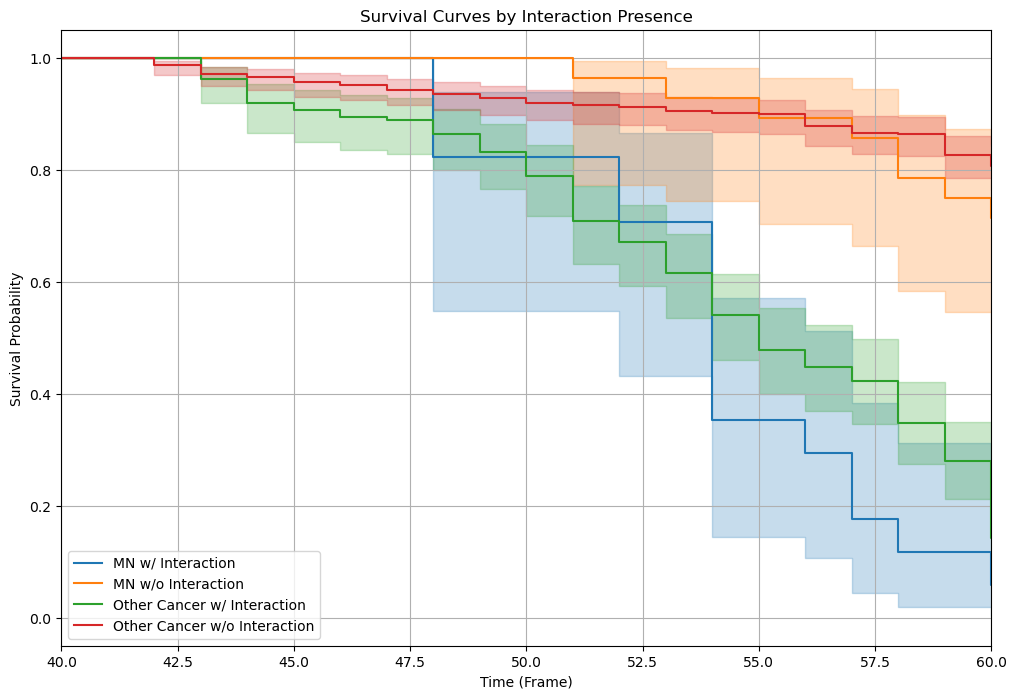

In [50]:
# === Prepare data ===
# Subgroup masks
mn_mask = mn_boolean == 1
rest_mask = mn_boolean == 0

# Split the data
mn_interaction_frames_list = [lst for lst, is_mn in zip(cancer_interaction_frames_list, mn_mask) if is_mn]
mn_death_frames = [df for df, is_mn in zip(cancer_death_frames, mn_mask) if is_mn]
mn_death_times = [dt for dt, is_mn in zip(death_times, mn_mask) if is_mn]
mn_censor_status = [cs for cs, is_mn in zip(censor_status_death, mn_mask) if is_mn]

rest_interaction_frames_list = [lst for lst, is_rest in zip(cancer_interaction_frames_list, rest_mask) if is_rest]
rest_death_frames = [df for df, is_rest in zip(cancer_death_frames, rest_mask) if is_rest]
rest_death_times = [dt for dt, is_rest in zip(death_times, rest_mask) if is_rest]
rest_censor_status = [cs for cs, is_rest in zip(censor_status_death, rest_mask) if is_rest]

# === Interaction flags ===
mn_interaction_flags = [
    1 if any(frame <= death for frame in frames) else 0
    for frames, death in zip(mn_interaction_frames_list, mn_death_frames)
]

rest_interaction_flags = [
    1 if any(frame <= death for frame in frames) else 0
    for frames, death in zip(rest_interaction_frames_list, rest_death_frames)
]

# === Split by interaction ===
def split_by_flag(death_times, censor_status, flags):
    with_flag = [(t, c) for t, c, f in zip(death_times, censor_status, flags) if f]
    without_flag = [(t, c) for t, c, f in zip(death_times, censor_status, flags) if not f]
    return zip(*with_flag), zip(*without_flag)

(mn_with_t, mn_with_c), (mn_without_t, mn_without_c) = split_by_flag(mn_death_times, mn_censor_status, mn_interaction_flags)
(rest_with_t, rest_with_c), (rest_without_t, rest_without_c) = split_by_flag(rest_death_times, rest_censor_status, rest_interaction_flags)

# === Plotting ===
kmf = KaplanMeierFitter()
plt.figure(figsize=(12, 8))

kmf.fit(list(mn_with_t), event_observed=list(mn_with_c), label="MN w/ Interaction")
kmf.plot()

kmf.fit(list(mn_without_t), event_observed=list(mn_without_c), label="MN w/o Interaction")
kmf.plot()

kmf.fit(list(rest_with_t), event_observed=list(rest_with_c), label="Other Cancer w/ Interaction")
kmf.plot()

kmf.fit(list(rest_without_t), event_observed=list(rest_without_c), label="Other Cancer w/o Interaction")
kmf.plot()

plt.title("Survival Curves by Interaction Presence")
plt.xlabel("Time (Frame)")
plt.ylabel("Survival Probability")
plt.grid(True)
plt.xlim(40, 60)
plt.legend()
plt.show()


In [51]:
# 1. MN w/ Interaction vs MN w/o Interaction
result_mn = logrank_test(
    list(mn_with_t), list(mn_without_t),
    event_observed_A=list(mn_with_c),
    event_observed_B=list(mn_without_c)
)
print(f"Log-rank p-value (MN w/ vs w/o Interaction): {result_mn.p_value:.4e}")

# 2. Other Cancer w/ Interaction vs w/o Interaction
result_rest = logrank_test(
    list(rest_with_t), list(rest_without_t),
    event_observed_A=list(rest_with_c),
    event_observed_B=list(rest_without_c)
)
print(f"Log-rank p-value (Other Cancer w/ vs w/o Interaction): {result_rest.p_value:.4e}")

# 3. MN w/ Interaction vs Other Cancer w/ Interaction
result_between = logrank_test(
    list(mn_with_t), list(rest_with_t),
    event_observed_A=list(mn_with_c),
    event_observed_B=list(rest_with_c)
)
print(f"Log-rank p-value (MN w/ Interaction vs Other Cancer w/ Interaction): {result_between.p_value:.4e}")

Log-rank p-value (MN w/ vs w/o Interaction): 2.2709e-07
Log-rank p-value (Other Cancer w/ vs w/o Interaction): 7.5941e-57
Log-rank p-value (MN w/ Interaction vs Other Cancer w/ Interaction): 2.0312e-01
